<a href="https://colab.research.google.com/github/semensorokin/data_augmetation/blob/master/BertTrecAugmentationWithVectorsBoolq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/UniversalEmb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/UniversalEmb


In [2]:
import pandas as pd
n_examples = 6000

labels = [i.split(' ', 1 )[0].split(':')[1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
texts = [ i.split(' ', 1 )[1][:-1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
train  = pd.DataFrame({'texts':texts, 'labels': labels})

labels_t = [i.split(' ', 1)[0].split(':')[1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
test  = pd.DataFrame({'texts':texts_t, 'labels': labels_t})
test.shape

(500, 2)

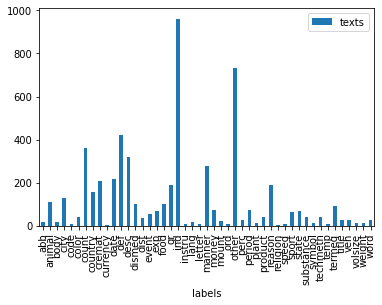

In [3]:
train.groupby('labels').count().plot.bar()

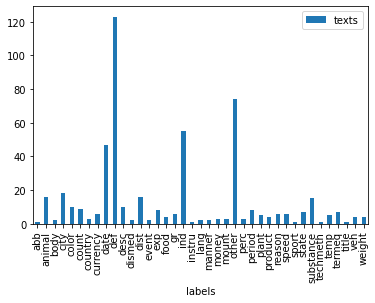

In [4]:
test.groupby('labels').count().plot.bar()

In [5]:
from scipy import stats
import numpy as np
#If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],\
               [i/np.sum(test.groupby('labels').count().values.flatten()) for i in test.groupby('labels').count().values.flatten()])

Ks_2sampResult(statistic=0.21222040370976542, pvalue=0.24282366077934026)

In [0]:
def creat_datasets(n, df):
  n_trains = []
  for i in range(0,df.shape[0],(df.shape[0])//n+1):
    #sample = df.sample((df.shape[0]//n)+1, random_state=i+100)
    sample = df[i:i+(df.shape[0])//n+1]
    n_trains.append(sample)
  return n_trains

train_samples = creat_datasets(1, train)

In [7]:
train_samples

[                                                  texts    labels
 0     How did serfdom develop in and then leave Russ...    manner
 1      What films featured the character Popeye Doyle ?    cremat
 2     How can I find a list of celebrities ' real na...    manner
 3     What fowl grabs the spotlight after the Chines...    animal
 4                       What is the full form of .com ?       exp
 ...                                                 ...       ...
 5447            What 's the shape of a camel 's spine ?     other
 5448           What type of currency is used in China ?  currency
 5449                    What is the temperature today ?      temp
 5450              What is the temperature for cooking ?      temp
 5451               What currency is used in Australia ?  currency
 
 [5452 rows x 2 columns]]

In [8]:
for sample in train_samples:
  print(stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],[i/np.sum(sample.groupby('labels').count().values.flatten()) for i in sample.groupby('labels').count().values.flatten()]))

Ks_2sampResult(statistic=0.0, pvalue=1.0)


In [9]:
!pip install transformers

     |████████████████████████████████| 573kB 5.0MB/s 
     |████████████████████████████████| 3.7MB 49.9MB/s 
     |████████████████████████████████| 1.0MB 42.7MB/s 
     |████████████████████████████████| 890kB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=d1980a38b4e2365408dee80c10d8d5e1a158ec4dca435dc9f7463aa498bef6da
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [10]:
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch

def prep_data(sentences, MAX_LEN = 64):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  input_ids = []
  for sent in tqdm(sentences):
      encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
      input_ids.append(encoded_sent[:MAX_LEN])
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  attention_masks = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
  return input_ids, attention_masks

Using TensorFlow backend.


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score

In [0]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
lbls2indx = {lbl:indx for indx, lbl in enumerate(train.labels.unique())}
indx2lbl = {indx:lbl for lbl, indx in lbls2indx.items()}

In [0]:
def lbl2indx(x):
    return lbls2indx[x]

In [0]:
from sklearn.metrics import classification_report

def train_bert(train, test):
  batch_size = 16
  

  print(train.groupby('labels').count().plot.bar())
  print("Labels unique in Train %s - amount:%i" % (train.labels.unique(), len(train.labels.unique())))
  print("Labels unique in Test %s - amount:%i" % (test.labels.unique(), len(test.labels.unique())))
  print(stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],\
               [i/np.sum(test.groupby('labels').count().values.flatten()) for i in test.groupby('labels').count().values.flatten()]))
  
  train['lb'] = train.labels.apply(lbl2indx)
  test['lb'] = test.labels.apply(lbl2indx)


  train_input_ids, train_attention_masks = prep_data(train.texts.values.tolist())
  test_input_ids, test_attention_masks = prep_data(test.texts.values.tolist())

  train_inputs = torch.tensor(train_input_ids)
  validation_inputs = torch.tensor(test_input_ids)

  train_labels = torch.tensor(train.lb.values.tolist())
  validation_labels = torch.tensor(test.lb.values.tolist())

  train_masks = torch.tensor(train_attention_masks)
  validation_masks = torch.tensor(test_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = len(list(lbls2indx.values())), output_attentions = False, output_hidden_states = True)
  model = model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 )
  epochs = 10
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 50, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  device = 'cuda'
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  loss_values = []

  for epoch_i in range(0, epochs):
      embeddings = []

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model.zero_grad()        

          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          loss  = outputs[0]
          embeddings.append(outputs[2][-1][:,0,:])
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      print("")
      print("Running Validation...")

      t0 = time.time()
      test_targets, test_pred_class = [], []

      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          batch = tuple(t.to(device) for t in batch)
          
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():        
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          logits = outputs[0]

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          test_targets.append(label_ids)
          test_pred_class.append(np.argmax(logits, axis=1))
          
          # Calculate the accuracy for this batch of test sentences.          
          # Accumulate the total accuracy.

          nb_eval_steps += 1
      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      f1 = f1_score(test_targets, test_pred_class, average='micro')
      print(classification_report(test_targets, test_pred_class))

      # Report the final accuracy for this validation run.
      print("  F1: {0:.4f}".format(f1))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  return model

Start fitting bert #1
AxesSubplot(0.125,0.125;0.775x0.755)
Labels unique in Train ['manner' 'cremat' 'animal' 'exp' 'ind' 'gr' 'title' 'def' 'date' 'reason'
 'event' 'state' 'desc' 'count' 'other' 'letter' 'religion' 'food'
 'country' 'color' 'termeq' 'city' 'body' 'dismed' 'mount' 'money'
 'product' 'period' 'substance' 'sport' 'plant' 'techmeth' 'volsize'
 'instru' 'abb' 'speed' 'word' 'lang' 'perc' 'code' 'dist' 'temp' 'symbol'
 'ord' 'veh' 'weight' 'currency'] - amount:47
Labels unique in Test ['dist' 'city' 'desc' 'def' 'date' 'gr' 'plant' 'reason' 'ind' 'weight'
 'other' 'substance' 'speed' 'mount' 'temp' 'period' 'count' 'animal'
 'food' 'state' 'termeq' 'money' 'currency' 'country' 'event' 'manner'
 'color' 'product' 'title' 'body' 'veh' 'lang' 'instru' 'abb' 'exp'
 'dismed' 'perc' 'sport' 'techmeth'] - amount:39
Ks_2sampResult(statistic=0.21222040370976542, pvalue=0.035508216408785764)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
100%|██████████| 500/500 [00:00<00:00, 6427.09it/s]



======== Epoch 1 / 10 ========
Training...
  Batch    40  of    341.    Elapsed: 0:00:06.
  Batch    80  of    341.    Elapsed: 0:00:11.
  Batch   120  of    341.    Elapsed: 0:00:17.
  Batch   160  of    341.    Elapsed: 0:00:22.
  Batch   200  of    341.    Elapsed: 0:00:28.
  Batch   240  of    341.    Elapsed: 0:00:33.
  Batch   280  of    341.    Elapsed: 0:00:38.
  Batch   320  of    341.    Elapsed: 0:00:44.

  Average training loss: 2.22
  Training epcoh took: 0:00:47

Running Validation...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           2       0.65      0.69      0.67        16
           3       0.00      0.00      0.00         8
           4       0.98      1.00      0.99        55
           5       0.62      0.83      0.71         6
           6       0.00      0.00      0.00         1
           7       0.81      1.00      0.89       123
           8       0.94      1.00      0.97        47
           9       0.62      0.83      0.71         6
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         7
          12       0.90      0.90      0.90        10
          13       0.53      1.00      0.69         9
          14       0.66      0.84      0.74        74
          17       0.23      0.75      0.35         4
          18       0.23      1.00      0.38         3
          19       1.00      1.00      1.00        10
          20       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       0.88      0.94      0.91        16
           3       0.83      0.62      0.71         8
           4       1.00      1.00      1.00        55
           5       0.83      0.83      0.83         6
           6       1.00      1.00      1.00         1
           7       0.95      1.00      0.98       123
           8       1.00      1.00      1.00        47
           9       1.00      1.00      1.00         6
          10       0.67      1.00      0.80         2
          11       0.88      1.00      0.93         7
          12       0.90      0.90      0.90        10
          13       0.82      1.00      0.90         9
          14       0.84      0.82      0.83        74
          17       1.00      0.75      0.86         4
          18       0.60      1.00      0.75         3
          19       1.00      1.00      1.00        10
          20       0.83    

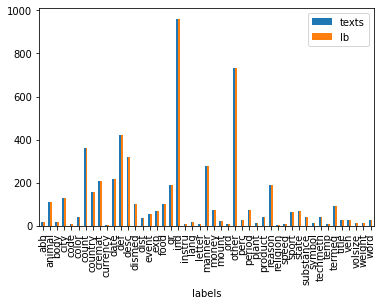

In [18]:
bert_models=[]
for ind,tr_part in enumerate(train_samples):
  print('Start fitting bert #{}'.format(ind+1))
  bert_models.append(train_bert(tr_part,test))


In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [20]:
len(bert_models)

1

In [0]:
from torch import nn
from tqdm import tqdm
def bert_vectors(model, sentences):
  batch_size = 16
  device = "cuda"

  train_input_ids, train_attention_masks = prep_data(sentences)

  train_inputs = torch.tensor(train_input_ids)
  train_labels = torch.tensor([0]*len(sentences))
  train_masks = torch.tensor(train_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

  model.eval()
  augmentations = []
  embeddings = []
  for batch in tqdm(train_dataloader):
      
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      embeddings.append(outputs[2][-1][:,0,:].detach().cpu().numpy())

  embeddings = np.concatenate(embeddings, axis = 0)

  return embeddings

In [22]:
for i, model in enumerate(bert_models):
  vectors = bert_vectors(model, train.texts.tolist())

100%|██████████| 341/341 [00:11<00:00, 29.74it/s]


In [23]:
train_vectors = pd.DataFrame({'vecs': [np.array(i) for i in vectors.tolist()], 'labels_indx' : train.labels.apply(lbl2indx).tolist() })
train_vectors.head()

,vecs,labels_indx
0,"[0.7357098460197449, -0.6352092623710632, 0.38...",0
1,"[0.8812758326530457, 0.09399615973234177, -0.2...",1
2,"[0.8160119652748108, -0.608461856842041, 0.392...",0
3,"[0.7787691950798035, 1.3727741241455078, -0.61...",2
4,"[0.30370819568634033, -0.425725519657135, 0.33...",3


In [0]:
center_of_classes = pd.DataFrame({'vecs': train_vectors.groupby('labels_indx')['vecs'].apply(np.mean).tolist(), 'labels_indx': [i for i in range(len(train.labels.unique()))]})

In [26]:
from scipy.spatial.distance import cosine
distances = []
lbl2center = {i: j for i,j in zip(center_of_classes.labels_indx, center_of_classes.vecs)}
for row in train_vectors.iterrows():
  distances.append(cosine(lbl2center[row[1].labels_indx], row[1].vecs))
train_vectors['distances'] = distances
train_vectors.head()

,vecs,labels_indx,distances
0,"[0.7357098460197449, -0.6352092623710632, 0.38...",0,0.005171
1,"[0.8812758326530457, 0.09399615973234177, -0.2...",1,0.009693
2,"[0.8160119652748108, -0.608461856842041, 0.392...",0,0.003692
3,"[0.7787691950798035, 1.3727741241455078, -0.61...",2,0.013641
4,"[0.30370819568634033, -0.425725519657135, 0.33...",3,0.029340


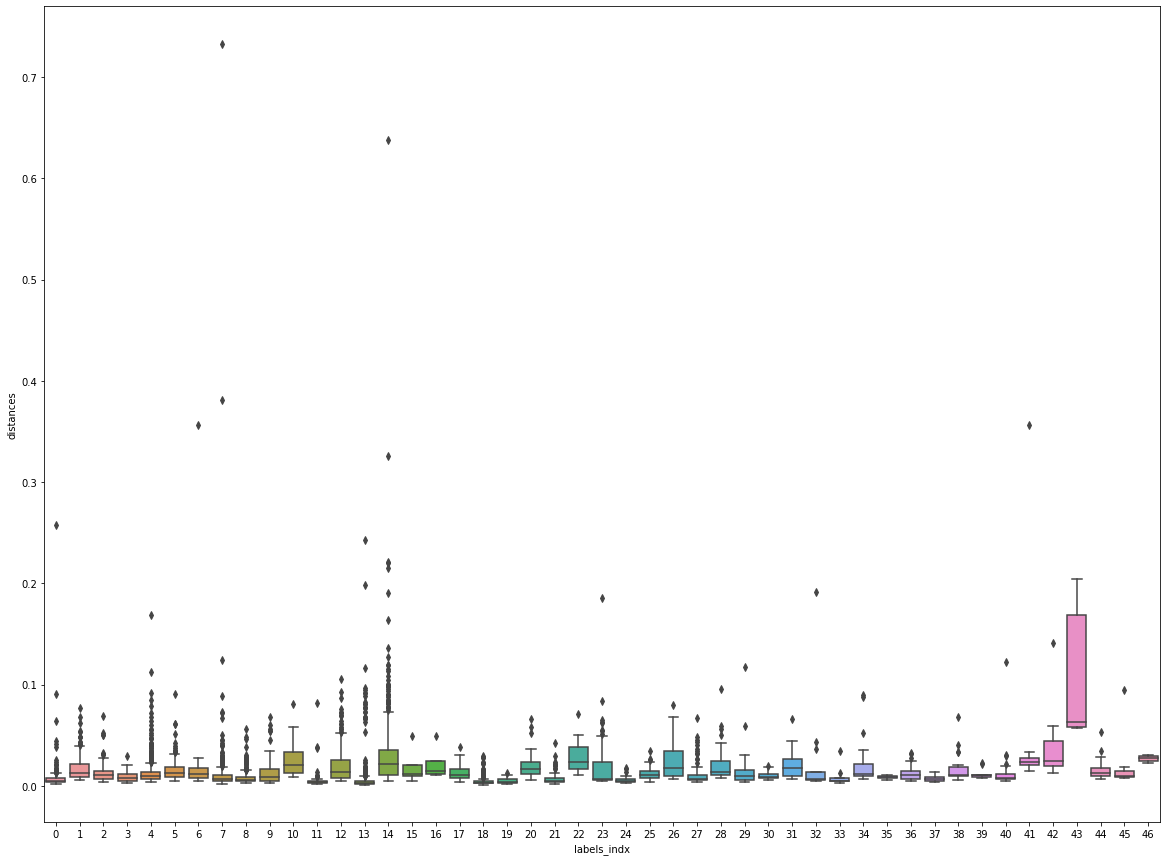

In [27]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20,15))
sns.boxplot(x="labels_indx", y="distances", data=train_vectors)
plt.show()

In [0]:
grouped = train_vectors.groupby('labels_indx')
min_mean_max_mapping = {} 
for name, values in grouped:
  min_mean_max_mapping[name] = {'min': values.distances.min(), 'mean':values.distances.mean(), 'max': values.distances.max(), 'center_emb': values.vecs.mean()}


In [0]:
vectors_with_centers = pd.concat([train_vectors, center_of_classes])

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(vectors_with_centers['vecs'].tolist())

In [0]:
import matplotlib.pyplot as plt
import numpy as np


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

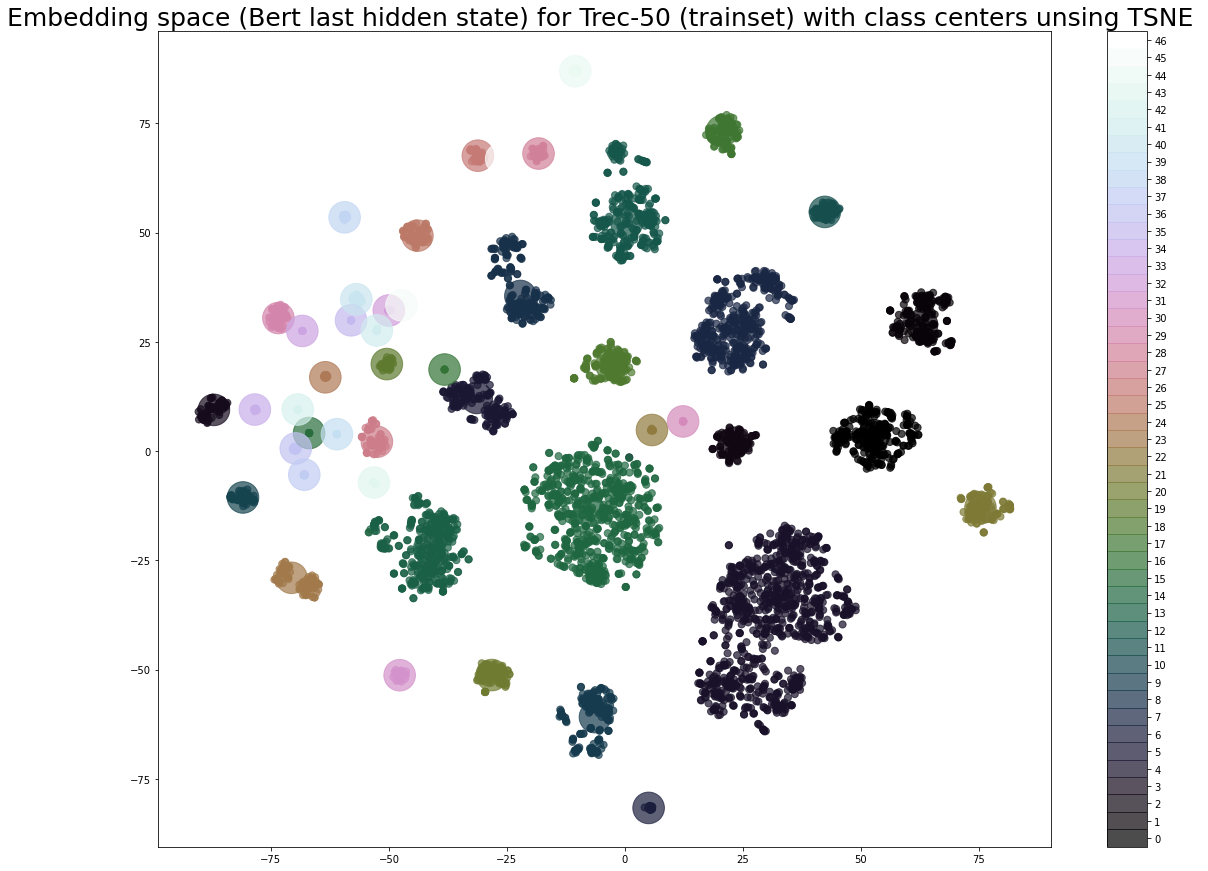

In [32]:
N = len(train.labels.unique())

x = [x for x,y in X_embedded][:-len(train.labels.unique())]
y = [y for x,y in X_embedded][:-len(train.labels.unique())]
c = vectors_with_centers.labels_indx[:-len(train.labels.unique())]

x_center = [x for x,y in X_embedded][-len(train.labels.unique()):]
y_center = [y for x,y in X_embedded][-len(train.labels.unique()):]
c_center = vectors_with_centers.labels_indx[-len(train.labels.unique()):]
                                                         
plt.figure(figsize=(20,15))
# Edit: don't use the default ('jet') because it makes @mwaskom mad...
plt.scatter(x, y, c=c, s=50, alpha=0.7, cmap=discrete_cmap(N, 'cubehelix'))
plt.scatter(x_center, y_center, c=c_center, s=1000, alpha=0.7, cmap=discrete_cmap(N, 'cubehelix'))
plt.colorbar(ticks=range(N))
plt.title('Embedding space (Bert last hidden state) for Trec-50 (trainset) with class centers unsing TSNE ', {'fontsize': 25})
plt.clim(-0.5, N - 0.5)
plt.show()

In [0]:
from torch import nn
from tqdm import tqdm
def bert_proba(mapping, model, sentences, boundary = 0.5):
  batch_size = 16
  device = "cuda"

  train_input_ids, train_attention_masks = prep_data(sentences)

  train_inputs = torch.tensor(train_input_ids)
  train_labels = torch.tensor([0]*len(sentences))
  train_masks = torch.tensor(train_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
  not_sampled = 0

  model.eval()
  augmentations = []
  for batch in tqdm(train_dataloader):
      
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():        
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

      embedings = outputs[2][-1][:,0,:]
      embedings = embedings.detach().cpu().numpy()
      logits = outputs[1]
      
      probs = nn.Softmax(dim=-1)(logits)
      probs = probs.detach().cpu().numpy()
  
      
      samples = []
      for indx, class_distribution in enumerate(probs.tolist()):
        if any(boundary<prob for prob in class_distribution):
          predicted_class_index = class_distribution.index(max(class_distribution)) #argmax
          sample_emb = embedings[indx]
          predicted_class_center = mapping[predicted_class_index]['center_emb']
          dist = cosine(sample_emb, predicted_class_center)
          if dist>= mapping[predicted_class_index]['min'] and dist<= (mapping[predicted_class_index]['max']):
            samples.append((indx, predicted_class_index ))
          else:
            not_sampled+=1
      augmentations.append(samples)
   
  aug_samples_indx = []
  for ind, i in enumerate(augmentations):
    if ind==0:
      aug_samples_indx.extend([(j,k) for j,k in i])
    else:
      aug_samples_indx.extend([((batch_size*ind)+j, k) for j,k in i])
  print()
  print(len(aug_samples_indx))
  print('Not sampled because of vectors distance:', not_sampled)
  return aug_samples_indx


# Data augmentations

### wiki

In [38]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def read_wiki(path, n_lines = 10000000):
  lines = open(path).readlines()[:n_lines]
  sentences = []
  for i in lines:
    sentences.extend(sent_tokenize(i)) 
  return sentences


wiki_sentences = read_wiki('wikitext-103/wiki.train.tokens')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### BoolQ

In [69]:
!pip install jsonlines

In [0]:
#https://github.com/google-research-datasets/boolean-questions
import jsonlines

def read_boolQ(file):
  q = []
  with jsonlines.open(file) as f:
    for line in f.iter():
        q.append(line['question'])
  return q

bool_q = read_boolQ('train.jsonl') + read_boolQ('dev.jsonl')  

In [73]:
len(bool_q)

12697

### SQUAD

In [200]:
sq_sents = [i[:-1] for i in open('SQuAD.txt').readlines()]
sq_sents[:10]

['When did Beyonce start becoming popular?',
 'After her second solo album, what other entertainment venture did Beyonce explore?',
 'In her music, what are some recurring elements in them?',
 "Beyonce's younger sibling also sang with her in what band?",
 'What town did Beyonce go to school in?',
 "Who decided to place Beyonce's group in Star Search the talent show?",
 "Which film featured Destiny's Child's first major single?",
 'What mental health issue did Beyonce go through?',
 '"Charlie\'s Angels" featured which single from the band members?',
 'Who did Beyonce star with in the movie, "Austin Powers in Goldmember"?']

### CNN

In [0]:
h0BwmD_VLjROrfTTljRDVZMFJnVWM

In [74]:
for i, model in enumerate(bert_models):
  augmenations_indexes = bert_proba(min_mean_max_mapping, model, bool_q, 0.75)

100%|██████████| 794/794 [00:27<00:00, 28.85it/s]


6036
Not sampled because of vectors distance: 3390


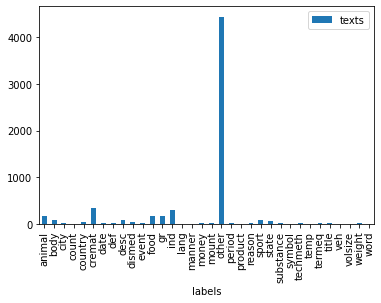

In [75]:
augmetation_squad = pd.DataFrame({"texts":[bool_q[i] for i,j in augmenations_indexes], "labels":[indx2lbl[j] for i,j in augmenations_indexes]})
augmetation_squad.groupby('labels').count().plot.bar()
augmetation_squad.to_csv('trec50_n1_bert_{}_boolq_075_with_min_max_distance.csv'.format(str(i)))

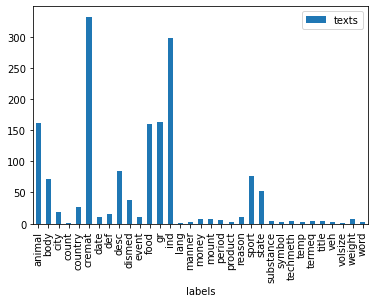

In [76]:
augmetation_squad_without_lbl =  augmetation_squad[augmetation_squad['labels']!='other']
augmetation_squad_without_lbl.groupby('labels').count().plot.bar()


In [0]:
import pandas as pd
trec50_n3_bert_0_squad_065 = pd.read_csv('trec50_n3_bert_0_squad_065.csv', index_col=0)
trec50_n3_bert_1_squad_065 = pd.read_csv('trec50_n3_bert_1_squad_065.csv', index_col=0)
trec50_n3_bert_2_squad_065 = pd.read_csv('trec50_n3_bert_2_squad_065.csv', index_col=0)

In [23]:
frameList = [trec50_n3_bert_0_squad_065,trec50_n3_bert_1_squad_065,trec50_n3_bert_2_squad_065]
for i in frameList:
  print(i.shape)
df_merge = frameList[0]
for df in frameList[1:]:       
    df_merge = pd.merge(df_merge, df, on=('texts',"labels"), how='inner')

(79527, 2)
(72972, 2)
(77903, 2)


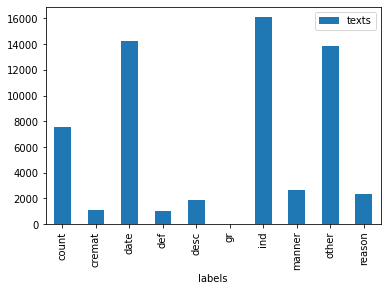

In [24]:
df_merge[['texts', 'labels']].groupby('labels').count().plot.bar()

In [77]:
import pandas as pd
n_examples = 5000

labels = [i.split(' ', 1 )[0].split(':')[1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
texts = [ i.split(' ', 1 )[1][:-1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
train  = pd.DataFrame({'texts':texts, 'labels': labels})

labels_t = [i.split(' ', 1)[0].split(':')[1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
test  = pd.DataFrame({'texts':texts_t, 'labels': labels_t})
test.shape

(500, 2)

In [78]:
augmetation_squad

,texts,labels
0,is elder scrolls online the same as skyrim,other
1,can you use oyster card at epsom station,other
2,is the federal court the same as the supreme c...,other
3,did abraham lincoln write the letter in saving...,other
4,does the icc has jurisdiction in the united st...,other
...,...,...
6031,is new york life insurance a public company,gr
6032,is time warner and time warner cable the same ...,gr
6033,is the iphone se before the iphone 6,other
6034,do exoplanetary systems follow the titus bode ...,other


In [0]:
#frames = [train, df_merge[['texts', 'labels']]]
frames = [augmetation_squad, train]
result = pd.concat(frames)
#result = train
#result = result.drop_duplicates('texts')

In [80]:
result

,texts,labels
0,is elder scrolls online the same as skyrim,other
1,can you use oyster card at epsom station,other
2,is the federal court the same as the supreme c...,other
3,did abraham lincoln write the letter in saving...,other
4,does the icc has jurisdiction in the united st...,other
...,...,...
4995,How do I contact Answers.com direct ?,manner
4996,What causes a person to have constantly sweaty...,reason
4997,What happened to Answers.com ?,desc
4998,What is the spectrum of a sine wave ?,def


In [0]:
#tr = {i:j for j, i in enumerate(train.labels.unique().tolist())}
def t(f):
  return lbls2indx[f]
result['lb'] = result.labels.apply(t)
test['lb'] = test.labels.apply(t)                  

In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [83]:
tf = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_df =0.98, min_df = 3)
tf_res = tf.fit_transform(result.texts)
test_transform = tf.transform(test.texts)
tf_res.shape

(11036, 9715)

In [0]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [0]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

class WordData(Dataset):
    
    def __init__(self, x_data, y_data):
        
        super().__init__()
        
        self.x_data = x_data
        self.y_data = torch.LongTensor([int(i) for i in y_data])
        
    
    def __len__(self):
        
        return self.x_data.shape[0]
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx].toarray()
        x = torch.FloatTensor(x)
        y = self.y_data[idx]
        
        return x, y


dataset_train = WordData(tf_res, result.lb)
dataset_test = WordData(test_transform, test.lb)

batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [0]:
from math import sqrt
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, inner_features2, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        gl = sqrt(6./(in_features+inner_features))
        self.linear_1.weight.data.uniform_(-gl, gl)
        self.non_linear_function = torch.nn.ReLU()
        self.drop_out = torch.nn.Dropout(0.18)
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=inner_features2)
        gl1 = sqrt(6./(inner_features+inner_features2))
        self.linear_2.weight.data.uniform_(-gl1, gl1)
        self.non_linear_function2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=inner_features2, out_features=out_features)
        gl2 = sqrt(6./(inner_features2+out_features))
        self.linear_3.weight.data.uniform_(-gl2, gl2)
  
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.drop_out(x)
        x = self.linear_2(x)
        x = self.non_linear_function2(x)
        x = self.linear_3(x)
        
        return x
    

In [0]:
model = MLP(in_features=tf_res.shape[1], inner_features=524, inner_features2=256, out_features=len(set(result.lb.unique())))

In [0]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005,  betas=(0.9, 0.999) )
# aka loss function
criterion = torch.nn.CrossEntropyLoss()

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [90]:

from sklearn.metrics import f1_score
epochs = 35
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = model(x).squeeze(1)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:     
        
        x = x.to(device)
        y = y.to(device)
       

        with torch.no_grad():
            pred = model(x).squeeze(1)

            pred = pred.cpu()
            y = y.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.7f}, test - {:.7f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 test - {:.4f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   5%|▍         | 512/11036 [00:00<00:02, 5074.32it/s, train_loss=2.99]


Losses: train - 3.0509359, test - 3.3953360
F1 test - 0.1480


Epoch 3:   7%|▋         | 768/11036 [00:00<00:02, 5057.57it/s, train_loss=2.44]


Losses: train - 1.8808291, test - 2.7685350
F1 test - 0.3740


Epoch 4:   7%|▋         | 768/11036 [00:00<00:02, 5019.19it/s, train_loss=2.08]


Losses: train - 1.3726040, test - 2.1205049
F1 test - 0.5560


Epoch 5:   5%|▍         | 512/11036 [00:00<00:02, 5109.01it/s, train_loss=1.79]


Losses: train - 0.9164440, test - 1.7293016
F1 test - 0.6380


Epoch 6:   7%|▋         | 768/11036 [00:00<00:01, 5218.38it/s, train_loss=1.54]


Losses: train - 0.5893751, test - 1.5167414
F1 test - 0.7060


Epoch 7:   7%|▋         | 768/11036 [00:00<00:01, 5180.18it/s, train_loss=1.35]


Losses: train - 0.4036733, test - 1.3994536
F1 test - 0.7120


Epoch 8:   7%|▋         | 768/11036 [00:00<00:01, 5245.35it/s, train_loss=1.2] 


Losses: train - 0.2928383, test - 1.3128799
F1 test - 0.7300


Epoch 9:   7%|▋         | 768/11036 [00:00<00:02, 5053.41it/s, train_loss=1.08]


Losses: train - 0.2273523, test - 1.2831382
F1 test - 0.7400


Epoch 10:   5%|▍         | 512/11036 [00:00<00:02, 5035.36it/s, train_loss=0.983]


Losses: train - 0.1700780, test - 1.2559891
F1 test - 0.7500


Epoch 11:   5%|▍         | 512/11036 [00:00<00:02, 4341.91it/s, train_loss=0.899]


Losses: train - 0.1376313, test - 1.2113608
F1 test - 0.7520


Epoch 11: 100%|██████████| 11036/11036 [00:02<00:00, 4856.08it/s, train_loss=0.832]



Losses: train - 0.1058516, test - 1.2361801
F1 test - 0.7620
Early stopping
